# Fraud detection with inbalanced data.
In this Notebook, we will try to find best model and parameter for fraudelent e-commerce data.\
The objective is how to work with inbalanced data.
1. Get an insight of data.
    

2. For pre-processing:
    * OneHotEncoder
    * StandardScalar
    * get_dummies
    * Feature selection (PCA, t-SNE)
    

3. For classifiers:
    * Decision Tree/Random Forest
    * Logistic Regression
    * XGBoost
    * SVC
    
4. Also we will use these methods because we have unbalanced data:
    * Weighting class
    * UnderSamling
    * OverSampling(SMOTE)

In [140]:
#For environment
import time
import datetime
from datetime import date
# from sklearn import datasets
import warnings
warnings.filterwarnings('ignore')

#Main libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
from matplotlib.pyplot import figure
from numpy import where
from collections import Counter
from numpy import mean
import matplotlib.patches as mpatches
from sklearn import set_config

#Pre-proccessing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE

#Classifier
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

#Sampling
from imblearn.under_sampling import RandomUnderSampler 
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import make_pipeline

#Metrics
from sklearn import metrics
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score, cross_val_predict,RepeatedStratifiedKFold, cross_validate
from sklearn.metrics import r2_score, mean_squared_error,f1_score, cohen_kappa_score, classification_report,confusion_matrix, precision_recall_fscore_support, precision_recall_curve, auc, roc_auc_score, roc_curve, recall_score

In [2]:
#Import data
df=pd.read_csv('datasets/Fraud_Data.csv')
ip=pd.read_csv('datasets/IpAddress_to_Country.csv')

In [3]:
df.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [4]:
ip.head()

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


Let's overview numerical values using `describe()` function.

In [5]:
df.describe()

,user_id,purchase_value,age,ip_address,class
count,151112.000000,151112.000000,151112.000000,1.511120e+05,151112.000000
mean,200171.040970,36.935372,33.140704,2.152145e+09,0.093646
std,115369.285024,18.322762,8.617733,1.248497e+09,0.291336
min,2.000000,9.000000,18.000000,5.209350e+04,0.000000
25%,100642.500000,22.000000,27.000000,1.085934e+09,0.000000
50%,199958.000000,35.000000,33.000000,2.154770e+09,0.000000
75%,300054.000000,49.000000,39.000000,3.243258e+09,0.000000
max,400000.000000,154.000000,76.000000,4.294850e+09,1.000000


There are 
* 151,112 entries
* Max price is 154, min price is 9, in average 36. 
* Average age is 33 years old.

For <b>ip</b> dataset, it is only IP address. 

Checking NA values in datasets:

In [6]:
df.isna().sum()

user_id           0
signup_time       0
purchase_time     0
purchase_value    0
device_id         0
source            0
browser           0
sex               0
age               0
ip_address        0
class             0
dtype: int64

In [7]:
ip.isna().sum()

lower_bound_ip_address    0
upper_bound_ip_address    0
country                   0
dtype: int64

No missing values in these datasets.

## 1. Find countries according to ip address


For each user, determine the country of origin from their IP address.\
If the the country is not specified, it will replace with `unknown`.

In [8]:
def find_country(ip_address):
    try:
        mask=ip[(ip['lower_bound_ip_address'] < ip_address) & (ip['upper_bound_ip_address'] > ip_address)]
        return mask['country'].iloc[0]
    except:
        return "unknown"

In [9]:
df['country']=df['ip_address'].apply(lambda x: find_country(x))

Let's see how many unique countries we have:

In [10]:
df['country'].nunique()

182

In [11]:
df['country'].value_counts()

United States                     58049
unknown                           21966
China                             12038
Japan                              7306
United Kingdom                     4490
                                  ...  
Tajikistan                            1
Vanuatu                               1
Saint Martin                          1
Gambia                                1
British Indian Ocean Territory        1
Name: country, Length: 182, dtype: int64

We notice last 5 rows(Yemen, Nauru, Madagascar, Gambia, San Marino)have only value of 1.\
We can find ignore these few purchases. Looking countries that have less than 8 purchases:

In [12]:
(df['country'].value_counts() < 8).sum()

56

56 entries is a very significant amount for this dataset.

In [13]:
#Finding the minority countries:
list_c=df.groupby('country').filter(lambda x: len(x) < 8)['country'].unique()

#Create a function replace minority countries with 'minority' name.
def replace_cntry(x):
    if x in list_c:
        return 'minority'
    else:
        return x

#Replace the countries
df['country']=df['country'].apply(lambda x:replace_cntry(x))

In [14]:
df['country'].value_counts()

United States     58049
unknown           21966
China             12038
Japan              7306
United Kingdom     4490
                  ...  
Barbados              9
Cuba                  9
Senegal               9
Honduras              9
Gabon                 9
Name: country, Length: 127, dtype: int64

Now we have 127 unique countries, min purchase count is 9.
Let's see the top 10 countries.

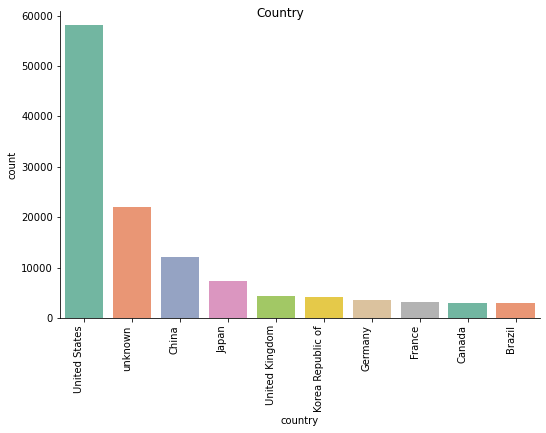

In [15]:
figure = sns.catplot(
    data=df,
    x='country',
    kind='count',
    palette='Set2',
    aspect=1.5,
    legend="True",
    order=df['country'].value_counts().nlargest(10).index
)
figure.fig.suptitle('Country')
figure.set_xticklabels(rotation=90, horizontalalignment='right')

US has most purchase.

## 2. Let's get an insight of the dataset

**How much fraud we have:**

In [16]:
df['class'].value_counts()

0    136961
1     14151
Name: class, dtype: int64

136961 non-frauds, 14151 frauds we have.

In [17]:
df['class'].value_counts()/df['class'].value_counts().sum()

0    0.906354
1    0.093646
Name: class, dtype: float64

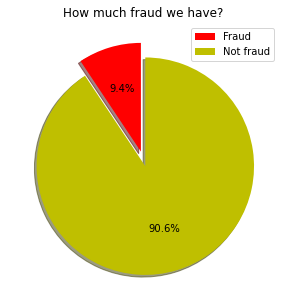

In [18]:
mask=df['class']==1
fraud_plot=len(df[mask])
not_fraud_plot=len(df['class'])-fraud_plot
sizes=(fraud_plot,not_fraud_plot)
explode=(0.07,0.07)

plt.figure(figsize=(5,5))
plt.pie(sizes, autopct='%1.1f%%', startangle=90, explode=explode, shadow=True, colors=['r','y'])
plt.legend(["Fraud","Not fraud"])
plt.title("How much fraud we have?")
plt.show()

We have 9.4% fraud which is very high in real life. Usually, frauds are 3% .

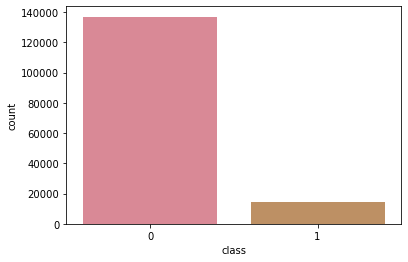

In [19]:
sns.countplot('class', data=df, palette=sns.husl_palette(9, s=0.7 ))

Unbalanced data, we see.

**How much repetitive fraudsters we have?**

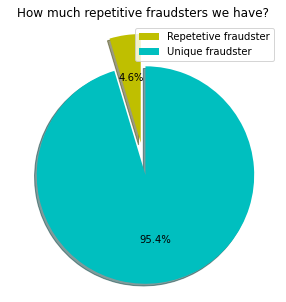

In [20]:
mask=df['class']==1
unique_device=len(df[mask]['device_id'].value_counts())/len(df['class'])
rep_device=1-unique_device
sizes=(unique_device, rep_device)
explode=(0.15,0.15)

plt.figure(figsize=(5,5))
plt.pie(sizes, autopct='%1.1f%%', startangle=90, explode=explode, shadow=True, colors=['y','c'])
plt.legend(["Repetetive fraudster","Unique fraudster"])
plt.title("How much repetitive fraudsters we have?")
plt.show()

We have 4.6% repetetive fraudsters, we should learn the lessons.

**Let's see purchase value(a.k.a price)**

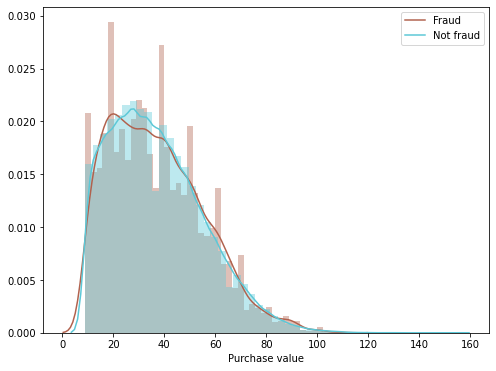

In [21]:
plt.figure(figsize=(8,6))
mask1=df['class']==1
mask2=df['class']==0
sns.distplot(df[mask1]['purchase_value'],
             kde_kws={"color": "#B1624EFF", "label": "Fraud"},
            color="#B1624EFF")
sns.distplot(df[mask2]['purchase_value'], 
             kde_kws={"color": "#5CC8D7FF", "label": "Not fraud"},
             color="#5CC8D7FF")
plt.xlabel("Purchase value")
plt.show()

It seems Fraud or not, customers buy between 20-40.

**Lets categorize source of access**

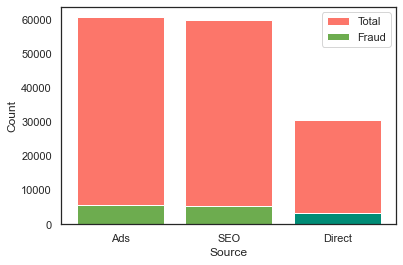

In [22]:
sns.set(style="white")

total_source=df['source'].value_counts()

mask=df['class']==1
unique_source=df[mask]['source'].value_counts()

names=unique_source.index
values=[total_source[0],
        unique_source[0],
        total_source[1],
        unique_source[1],
        total_source[2],
        unique_source[2]
       ]

plt.bar(names[0], values[0], color="#FC766AFF")
plt.bar(names[0], values[1], color="#6DAC4FFF")

plt.bar(names[1], values[2], color="#FC766AFF")
plt.bar(names[1], values[3], color="#6DAC4FFF")

plt.bar(names[2], values[4], color="#FC766AFF")
plt.bar(names[2], values[5], color="#008C76FF")

plt.ylabel("Count")
plt.xlabel("Source")
plt.legend(["Total","Fraud"])

plt.show()

Fraudsters are mostly coming from Ads and SEO. Directly accessing fraudesters are minority here.

**What kind of browser fraudsters are using?**

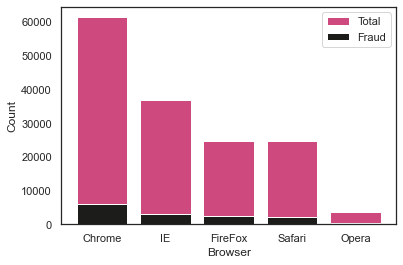

In [23]:
total_browsers=df['browser'].value_counts()

mask=df['class']==1
unique_browsers=df[mask]['browser'].value_counts()
names=unique_browsers.index
values=[total_browsers[0],
        unique_browsers[0],
        total_browsers[1],
        unique_browsers[1],
        total_browsers[2],
        unique_browsers[2],
        total_browsers[3],
        unique_browsers[3],
        total_browsers[4],
        unique_browsers[4]
       ]

plt.bar(names[0], values[0], color="#CE4A7EFF")
plt.bar(names[0], values[1], color="#1C1C1BFF")
plt.bar(names[1], values[2], color="#CE4A7EFF")
plt.bar(names[1], values[3], color="#1C1C1BFF")
plt.bar(names[2], values[4], color="#CE4A7EFF")
plt.bar(names[2], values[5], color="#1C1C1BFF")
plt.bar(names[3], values[6], color="#CE4A7EFF")
plt.bar(names[3], values[7], color="#1C1C1BFF")
plt.bar(names[4], values[8], color="#CE4A7EFF")
plt.bar(names[4], values[9], color="#1C1C1BFF")

plt.ylabel("Count")
plt.xlabel("Browser")
plt.legend(['Total', 'Fraud'])

plt.show()

Fraudsters are using mostly Chrome. Secondly, they use Internet Explorer. For other browsers, it seems almost same. 

**Let's see the correlation of sex and age of fraudsters.**

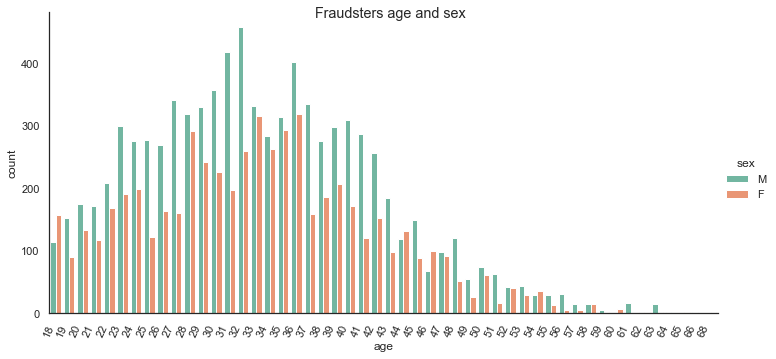

In [24]:
figure = sns.catplot(
    data=df[mask],
    x='age',
    hue='sex',
    kind='count',
    palette='Set2',
    aspect=2.0,
    legend="True"
)
figure.fig.suptitle('Fraudsters age and sex')
figure.set_xticklabels(rotation=65, horizontalalignment='right')

Most male fraudsters are early 30's, but for felames, late 30's.

**I want to know if there is any significance for time difference between signup time and purchase time**

In [25]:
#Get time difference in seconds:
df['signup_time_1']=df['signup_time'].apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))
df['purchase_time_1']=df['purchase_time'].apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))
df['duration'] = df['purchase_time_1'].sub(df['signup_time_1']).dt.total_seconds()
df.drop(columns=['signup_time','purchase_time','signup_time_1','purchase_time_1'], 
        inplace=True) #drop access time, purchase time columns

In [26]:
df

,user_id,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,duration
0,22058,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,4506682.0
1,333320,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,17944.0
2,1359,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,1.0
3,150084,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,unknown,492085.0
4,221365,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,4361461.0
...,...,...,...,...,...,...,...,...,...,...,...
151107,345170,43,XPSKTWGPWINLR,SEO,Chrome,M,28,3.451155e+09,1,United States,5261233.0
151108,274471,35,LYSFABUCPCGBA,SEO,Safari,M,32,2.439047e+09,0,Netherlands,931270.0
151109,368416,40,MEQHCSJUBRBFE,SEO,IE,F,26,2.748471e+09,0,Japan,6681616.0
151110,207709,46,CMCXFGRHYSTVJ,SEO,Chrome,M,37,3.601175e+09,0,United States,5146119.0


In [27]:
df['duration'].describe()

count    1.511120e+05
mean     4.932029e+06
std      3.126263e+06
min      1.000000e+00
25%      2.186754e+06
50%      4.926346e+06
75%      7.644525e+06
max      1.036797e+07
Name: duration, dtype: float64

In [28]:
mask1=df[mask]['duration']>1.0
mask.describe()

count     151112
unique         2
top        False
freq      136961
Name: class, dtype: object

**As we can see here, there are 1.0 seconds duration. Let's see if it is only for visiting the page or they are also classified as a fraud.**

In [29]:
mask=df['class']==1
(df[mask]['duration'] == 1.0).value_counts()

True     7600
False    6551
Name: duration, dtype: int64

It seems 7,600 cases are fraud!! More than 50%.

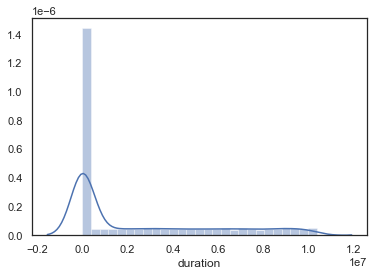

In [30]:
sns.distplot(df[mask]['duration'])

_As we assumed, less than 1 seconds distribution seems high._

Let's see if user ID has any significant meaning.

In [31]:
len(df.groupby('user_id')['class'].nunique())

151112

It seems user_id is everytime unique. We have 151,112 user ID's. We can drop this column later, since it doesn't include meaningful idea.

In [32]:
len(df.groupby('ip_address')['class'].nunique())

143512

In [33]:
len(df.groupby('device_id')['class'].nunique())

137956

We won't use these 2 columns due to less meaningfullness.

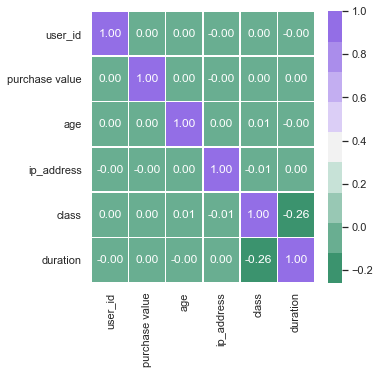

In [34]:
#Seeing feature corr

df.rename(columns=
               {
                   'purchase_value':'purchase value',
                   'duration':'duration'
               },
               inplace=True)
corr = df.corr()
# corr = df_plot.corr('pearson').sort_values(by='class')
fig, ax = plt.subplots(figsize=(5, 5))
colormap = sns.diverging_palette(150, 275, s=80, l=55, n=9)
dropSelf = np.zeros_like(corr)
dropSelf[np.triu_indices_from(dropSelf)] = False
colormap = sns.diverging_palette(150, 275, s=80, l=55, n=9)
sns.heatmap(corr, cmap=colormap, linewidths=.5, annot=True, fmt=".2f", mask=dropSelf)
plt.show()

It doesn't give us significant meaning. Unless duration seems opposite correlation with class.

After analyzing data:
1. We have unbalanced data: 9.4% fraud, 90.6% non-fraud.
2. It seems duration have opposite corr with class.
3. Most frauds are mainly 20-40 euro products. 
    

## 3. Modeling

Let's train data and get prediction.
* 3.1 Let's see without any tuning, how these 2 models can predict:Logistic Regression, DecisionTree/RandomForest
* 3.2 Weighting, Undersampling and Oversampling for unbalanced data.

In [35]:
df

,user_id,purchase value,device_id,source,browser,sex,age,ip_address,class,country,duration
0,22058,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,4506682.0
1,333320,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,17944.0
2,1359,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,1.0
3,150084,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,unknown,492085.0
4,221365,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,4361461.0
...,...,...,...,...,...,...,...,...,...,...,...
151107,345170,43,XPSKTWGPWINLR,SEO,Chrome,M,28,3.451155e+09,1,United States,5261233.0
151108,274471,35,LYSFABUCPCGBA,SEO,Safari,M,32,2.439047e+09,0,Netherlands,931270.0
151109,368416,40,MEQHCSJUBRBFE,SEO,IE,F,26,2.748471e+09,0,Japan,6681616.0
151110,207709,46,CMCXFGRHYSTVJ,SEO,Chrome,M,37,3.601175e+09,0,United States,5146119.0


In [36]:
# Separate target variable Y from features X
df_small=df.drop(columns=['user_id', 'device_id', 'ip_address'])

target_name = 'class'

print("Separating labels from features...")
X = df_small.drop(target_name, axis=1)
y = df_small[target_name]

#Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert pandas DataFrames to numpy arrays before using scikit-learn
X_train.values
y_train.values

Separating labels from features...


array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [38]:
# Create pipeline for numeric features
numeric_features = ['purchase value', 'age', 'duration'] # Positions of numeric columns in X_train/X_test
numeric_transformer = Pipeline(
    steps=[
    ('scaler', StandardScaler())
])

# Create pipeline for categorical features
categorical_features = ['source', 'browser', 'sex', 'country'] # Positions of categorical columns in X_train/X_test
categorical_transformer = Pipeline(
    steps=[
    ('encoder', OneHotEncoder(drop='first')) 
        # first column will be dropped to avoid creating correlations between features
    ])

# Use ColumnTranformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])
set_config(display='diagram')

In [40]:
# Preprocessings on train set
print("Performing preprocessings on train, test set...")
X_train_pre = preprocessor.fit_transform(X_train)
X_test_pre = preprocessor.transform(X_test) # Don't fit again !!
print('...Done.')
print()

Performing preprocessings on train, test set...
...Done.



In [41]:
# Train model
RF = RandomForestClassifier()

parameters = {'n_estimators':range(10,50,10),
              'max_depth':range(1,5),
              'max_features':range(1,5)
             }
    
clf = GridSearchCV(estimator=RF, param_grid=parameters, cv=5, verbose=1).fit(X_train_pre, y_train)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 320 out of 320 | elapsed:  2.4min finished


In [42]:
#Checking the score of train data
y_pred_RF = clf.predict(X_test_pre)
print(clf.best_score_)
print(clf.best_params_)

0.9065175491995054
{'max_depth': 1, 'max_features': 1, 'n_estimators': 10}


In [43]:
# Running the fit
RF = RandomForestClassifier(max_depth=4, max_features = 4, n_estimators = 10)
RF.fit(X_train_pre, y_train)

RandomForestClassifier(max_depth=4, max_features=4, n_estimators=10)

In [44]:
# Printing the Training Score
print("Training score data: ")
print(RF.score(X_train_pre, y_train))

Training score data: 
0.9065175491566644


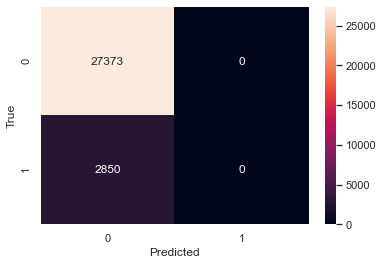

In [45]:
cm = confusion_matrix(y_test, y_pred_RF)
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

It seems not good. Because our training data was HIGHLY unbalanced. I have False Negative (it couldn't detect actual fraud).\
Let's see in Logistic Regression classifier.

In [46]:
# Train model
logisticReg = LogisticRegression()

parameters = {
    "C":np.logspace(-4, 4, 20),
    "penalty":["l1","l2"]# l1 lasso l2 ridge
}

clf = GridSearchCV(estimator=logisticReg, param_grid=parameters, cv=5, verbose=1, scoring='roc_auc').fit(X_train_pre, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  1.1min finished


In [47]:
#Checking the score of train data
y_pred_LR = clf.predict(X_test_pre)
print(clf.best_score_)
print(clf.best_params_)

0.7635692966995757
{'C': 0.0001, 'penalty': 'l2'}


In [49]:
# Running the fit
LR = LogisticRegression(C=0.0001, penalty = "l2")
LR.fit(X_train_pre, y_train)

LogisticRegression(C=0.0001)

In [50]:
# Printing the Training Score
print("Training score data: ")
print(LR.score(X_train_pre, y_train))

Training score data: 
0.9065175491566644


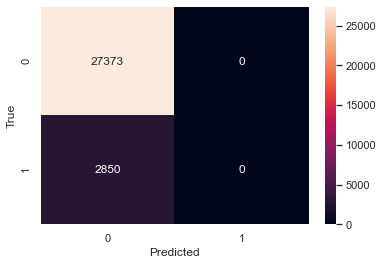

In [51]:
cm = confusion_matrix(y_test, y_pred_LR)
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

It is still not good.\
Let's use weighting class.

### 3.2. Weighted class

In [52]:
df_small

,purchase value,source,browser,sex,age,class,country,duration
0,34,SEO,Chrome,M,39,0,Japan,4506682.0
1,16,Ads,Chrome,F,53,0,United States,17944.0
2,15,SEO,Opera,M,53,1,United States,1.0
3,44,SEO,Safari,M,41,0,unknown,492085.0
4,39,Ads,Safari,M,45,0,United States,4361461.0
...,...,...,...,...,...,...,...,...
151107,43,SEO,Chrome,M,28,1,United States,5261233.0
151108,35,SEO,Safari,M,32,0,Netherlands,931270.0
151109,40,SEO,IE,F,26,0,Japan,6681616.0
151110,46,SEO,Chrome,M,37,0,United States,5146119.0


In [55]:
#Split the data

df_weight=df_small

target_name = 'class'

X = df_weight.drop(target_name, axis=1)
y = df_weight[target_name]

#Use get_dummies to categorical features
X=pd.get_dummies(X, drop_first=True)

#Let's split data into train and test with 80%, 20% size:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size = 0.2, random_state=42)

In [56]:
X

,purchase value,age,duration,source_Direct,source_SEO,browser_FireFox,browser_IE,browser_Opera,browser_Safari,sex_M,...,country_United Arab Emirates,country_United Kingdom,country_United States,country_Uruguay,country_Uzbekistan,country_Venezuela,country_Viet Nam,country_Zambia,country_minority,country_unknown
0,34,39,4506682.0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,16,53,17944.0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,15,53,1.0,0,1,0,0,1,0,1,...,0,0,1,0,0,0,0,0,0,0
3,44,41,492085.0,0,1,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,1
4,39,45,4361461.0,0,0,0,0,0,1,1,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151107,43,28,5261233.0,0,1,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
151108,35,32,931270.0,0,1,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
151109,40,26,6681616.0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
151110,46,37,5146119.0,0,1,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0


In [57]:
#Let's normalize the data
sc_x = StandardScaler()
X_train = sc_x.fit_transform(X_train)
X_test = sc_x.transform(X_test)

Estimate class weights for unbalanced datasets. If ‘balanced’, class weights will be given by n_samples / (n_classes * np.bincount(y)).\
Or we can just specify `{ 0:0.1, 1:0.9 }` by penalizing the mis-classification of minority class more.\
More about class_weight [here](https://machinelearningmastery.com/cost-sensitive-logistic-regression/).

In [58]:
# Using class_weight parameter
logRegress = LogisticRegression(class_weight='balanced')

parameters = {
    "C":np.logspace(-4, 4, 20),
    "penalty":["l1","l2"]
}
    
clf_w = GridSearchCV(estimator=logRegress, param_grid=parameters, cv=5, verbose=1).fit(X_train, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  1.6min finished


In [59]:
#Checking the score of train data
y_pred_logreg = clf_w.best_estimator_.predict(X_test)

I will find the `f1_score`(average of precision and recall) and `Cohen Kappa score` for the classifiers, since using `accuracy score` seems not realistic.\
If both score is cloes to 1, our model is good.\
This metric work really well for imbalanced problems and seems like a great companion/alternative to accuracy.\
Find more [here](https://scikit-learn.org/stable/modules/model_evaluation.html?highlight=cohen)

In [60]:
print("f1 score: %1.3f" % f1_score(y_test, y_pred_logreg))
print("Kappa coefficient: %1.3f" % cohen_kappa_score(y_test, y_pred_logreg, labels=None))

f1 score: 0.270
Kappa coefficient: 0.140


**This seems not good**

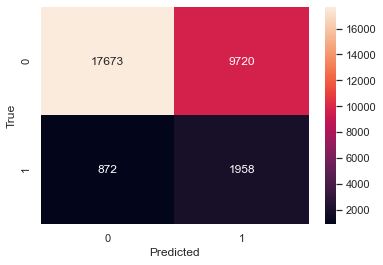

In [90]:
cm = confusion_matrix(y_test, y_pred_logreg)
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Doesn't work well. We now have more Type I error(False Positive).

### 3.3  Ovesampling and Dimenion Reduction

Now we will use manually ovesampling and undersampling.

We will use combine of undersampling and oversampling. Because it works when we combine these 2 methods at same time. \
First oversamples the minority class(class 1) to 10 percent of the majority class, then under samples the majority class(class 0) to 50 percent more than the minority class.

About undersampling and oversampling [here](https://towardsdatascience.com/having-an-imbalanced-dataset-here-is-how-you-can-solve-it-1640568947eb).

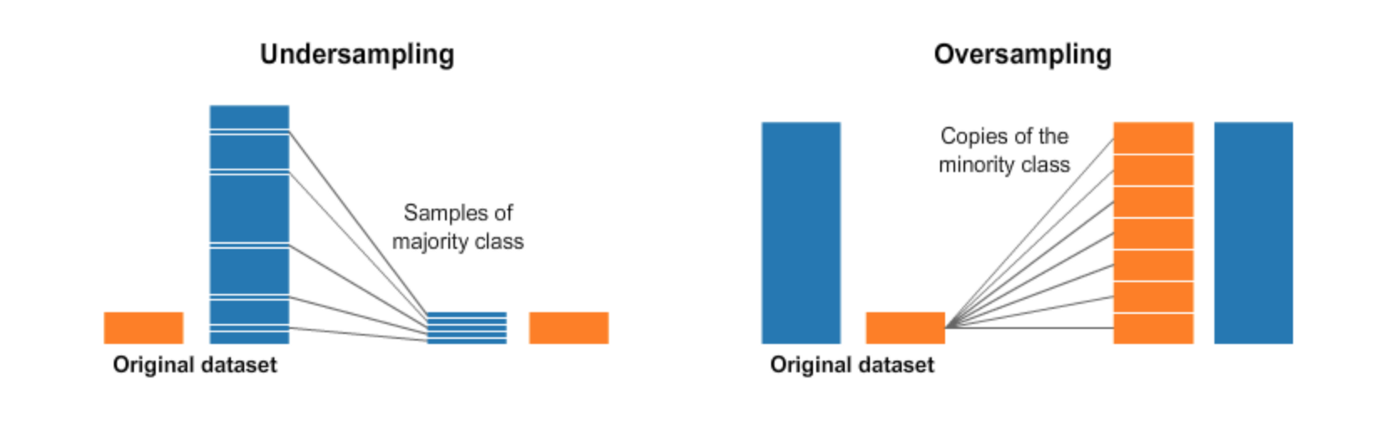

I will need subsamples to see if our model is overfitting or not.\
For that, first we will shuffle the data using "sample" for items randomly sampled.

In [63]:
df_s = df_small.sample(frac=1)

# Amount of fraud classes 14151 rows:
fraud_df = df_s.loc[df_s['class'] == 1]
non_fraud_df = df_s.loc[df_s['class'] == 0][:14151]

non_nd_df = pd.concat([fraud_df, non_fraud_df])

# Shuffle dataframe rows
df_small_data = non_nd_df.sample(frac=1, random_state=42)

df_small_data.head()

,purchase value,source,browser,sex,age,class,country,duration
4013,15,Direct,IE,F,39,1,Japan,1.0
81289,29,Ads,IE,F,46,0,Korea Republic of,97259.0
134459,14,Ads,IE,F,25,0,United States,3681742.0
61111,40,Direct,IE,M,34,0,United States,1855613.0
145045,18,Direct,Chrome,F,30,1,Russian Federation,8111728.0


In [64]:
df_small_data.shape

(28302, 8)

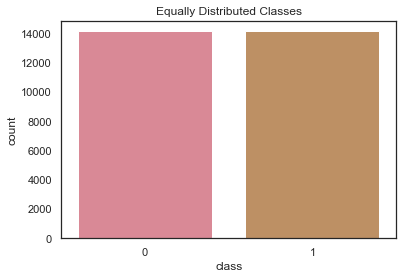

In [65]:
#Let's see our new testing data proportion

sns.countplot('class', data=df_small_data, palette=sns.husl_palette(9, s=0.7 ))
plt.title('Equally Distributed Classes', fontsize=12)
plt.show()

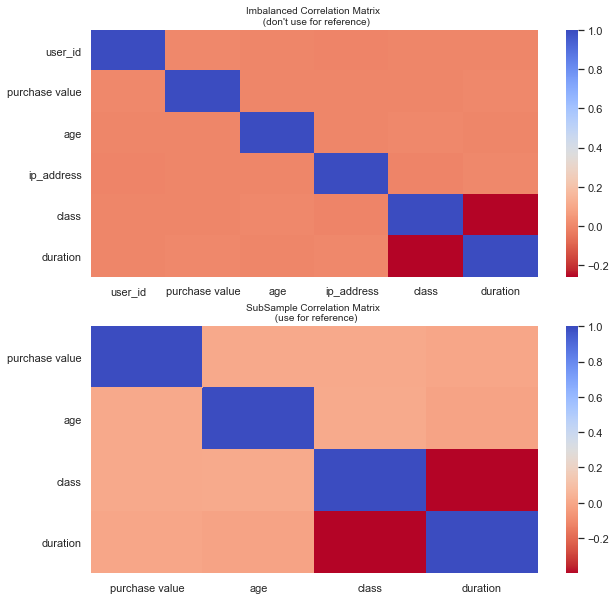

In [66]:
#Let's see corr matrix

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,10))

#Original dataset
corr = df.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':10}, ax=ax1)
ax1.set_title("Imbalanced Correlation Matrix \n (don't use for reference)", fontsize=10)

#New dataset
sub_sample_corr = df_small_data.corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot_kws={'size':10}, ax=ax2)
ax2.set_title('SubSample Correlation Matrix \n (use for reference)', fontsize=10)
plt.show()

Still no significant relationship.
##### Feature selection
We can't see significant correlation with corr matrix, let's see with feature selection.

* Dimensionality reduction using truncated SVD-TruncatedSVD (aka LSA).
  This transformer performs linear dimensionality reduction by means of truncated (SVD). Contrary to PCA, it can work with sparse matrices efficiently. Since we have highly sparse data, we should use TruncatedSVD.
* t-distributed Stochastic Neighbor Embedding (t-SNE)
  t-SNE is a tool to visualize high-dimensional data. 

In [67]:
#Split data
X = df_small_data.drop('class', axis=1)
y = df_small_data['class']

X.values
X_data = preprocessor.fit_transform(X)

In [68]:
X_data

<28302x131 sparse matrix of type '<class 'numpy.float64'>'
	with 163734 stored elements in Compressed Sparse Row format>

##### PCA implementation

For truncatedSVD `n_components=20` means, I use best 20 components which will improve my classification. More about [here](https://chrisalbon.com/machine_learning/feature_engineering/select_best_number_of_components_in_tsvd/).

_Below command will take time:_

In [70]:
#TruncatedSVD
X_reduce_model = TruncatedSVD(n_components=20, algorithm='randomized', random_state=42).fit(X_data)
X_svd = X_reduce_model.transform(X_data)

#Then t-SNE
X_tsne_model = TSNE(verbose=2, perplexity=80, min_grad_norm=1E-12, n_iter=3000).fit(X_data)
X_tsne = X_tsne_model.transform(X_data)

Plotting PCA and TSNE

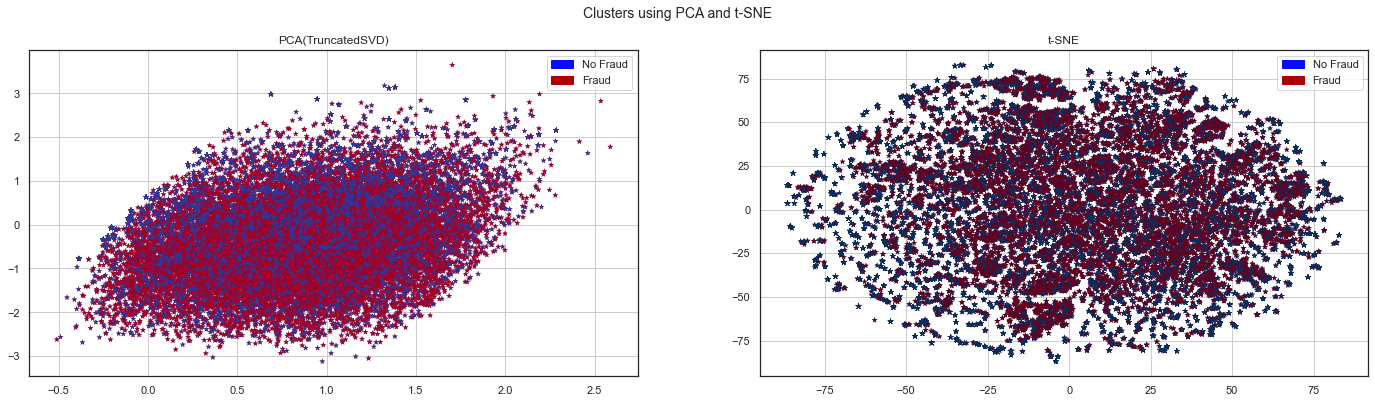

In [76]:
f1, ax1 = plt.subplots(1, 2, figsize=(24,6))
f1.suptitle('Clusters using PCA and t-SNE', fontsize=14)
 
c_blue = mpatches.Patch(color='#0A0AFF', label='No Fraud')
c_red = mpatches.Patch(color='#AF0000', label='Fraud')

#TruncatedSVD
ax1[0].scatter(X_svd[:, 0], X_svd[:, 1], c=(y == 0), cmap='RdYlBu', marker='*', label='No Fraud', linewidths=0)
ax1[0].scatter(X_svd[:, 0], X_svd[:, 1], c=(y == 1), cmap='RdYlBu', marker='*',label='Fraud', linewidths=0)
ax1[0].set_title('PCA(TruncatedSVD)')
ax1[0].grid(True)
ax1[0].legend(handles=[c_blue, c_red])

#t-SNE
ax1[1].scatter(X_tsne[:, 0], X_tsne[:, 1], c=(y == 0), cmap='RdYlBu', marker='*',label='No Fraud', linewidths=0)
ax1[1].scatter(X_tsne[:, 0], X_tsne[:, 1], c=(y == 1), cmap='RdYlBu', marker='*',label='Fraud', linewidths=0)
ax1[1].set_title('t-SNE')
ax1[1].grid(True)
ax1[1].legend(handles=[c_blue, c_red])

plt.show()

We can't see any insight of the data.
* Cleaned the data-yes
* Balanced the data-yes
* Weighted the data-yes
* Dimension reduction done-yes

Still data seems strange-only answer is now, this data is **ARTIFICIAL!**\
But, I can't stop here. I want explore more.

### 3.4 Random oversampling and undersampling

Object to over-sample the minority class(es) by picking samples at random with replacement.\
In this section I combining OverSampling and UnderSampling. It seems we can get better result when we combine 2 methods.\
* Applying OverSampling on minority class labels by 20 %.
* After, UnderSampling on majority class labels by 60%.\
We might not lose major datapoints. Then we fit Random Forest classifier.

In [138]:
#Split the data
target_name = 'class'

X = df_small.drop(target_name, axis=1)
y = df_small[target_name]

#Use get_dummies to categorical features
X=pd.get_dummies(X, drop_first=True)

#Let's split data into train and test with 80%, 20% size:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size = 0.2, random_state=42)

#Let's normalize the data
sc_x = StandardScaler()
X_train = sc_x.fit_transform(X_train)
X_test = sc_x.transform(X_test)

# Model:
clf = RandomForestClassifier()

# Sampling
# over = RandomOverSampler(sampling_strategy=0.2)
# under = RandomUnderSampler(sampling_strategy=0.6)

# Pipeline for 2 sampling
pipeline_uo = Pipeline(steps=
                    [
#                         ('o', over), 
#                      ('u', under), 
                     ('m', clf)
                    ])

# Using GridSearch for evaluation
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

# Getting scores
scores = cross_val_score(estimator=pipeline_uo, X=X_train, y=y_train, scoring='f1', cv=cv, n_jobs=-1, verbose=1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


KeyboardInterrupt: 

In [143]:
#Split the data
target_name = 'class'

X = df_small.drop(target_name, axis=1)
y = df_small[target_name]

#Use get_dummies to categorical features
X=pd.get_dummies(X, drop_first=True)

#Let's split data into train and test with 80%, 20% size:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size = 0.2, random_state=42)

#Let's normalize the data
sc_x = StandardScaler()
X_train = sc_x.fit_transform(X_train)
X_test = sc_x.transform(X_test)

# under = RandomUnderSampler(sampling_strategy=0.6)
rus = RandomUnderSampler(replacement=False)
X_train_subsample, y_train_subsample = rus.fit_sample(X_train, y_train)
print(X_train.shape)
print(X_train_subsample.shape)
print(np.bincount(y_train_subsample))

(120889, 136)
(22642, 136)
[11321 11321]


In [145]:
#Fitting the UnderSampling
undersample_pipe_rf = make_pipeline(RandomUnderSampler(),
                                    RandomForestClassifier())

scores = cross_validate(undersample_pipe_rf,
                        X_train, y_train, cv=10,
                        scoring=('roc_auc', 'average_precision'))

scores['test_roc_auc'].mean(), scores['test_average_precision'].mean()

(0.7707220953072579, 0.6295060299333193)

In [116]:
print('f1 score (mean): %.3f' % mean(scores))
(0.7697418901269385, 0.629515014811384)

AttributeError: 'RandomUnderSampler' object has no attribute 'shape'

In [89]:
print('roc auc (mean): %.3f' % mean(score_roc))
print('f1 score (mean): %.3f' % mean(score_f1))

roc auc (mean): 0.770
f1 score (mean): 0.653


f1 score sees realistic. Let's train the model and see the result.

ValueError: x and y must be the same size

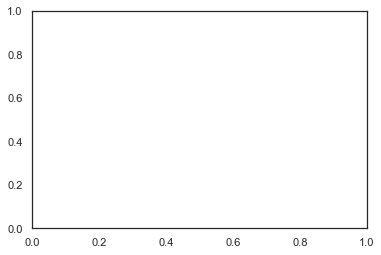

In [113]:
# y_pred_rf = cross_val_predict(lm,df,y,cv=5)
# precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred_rf, average='micro') 
# print(fscore)
# f1_score(y_test, y_pred_rf)
# print(y_pred_rf.shape)
# print(y_test.shape)


fig, ax = plt.subplots()
ax.scatter(y, y_pred_rf, edgecolors=(0, 0, 0))
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

In [ ]:
cm = confusion_matrix(y_test, y_pred_logreg)
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [81]:
# combination of SMOTE and random undersampling for imbalanced classification
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
# generate dataset
X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0, n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=1)
# define model
model = DecisionTreeClassifier()
# define pipeline
over = SMOTE(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('o', over), ('u', under), ('m', model)]
pipeline = Pipeline(steps=steps)
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.3f' % mean(scores))

array([0, 0, 0, ..., 0, 0, 0])

In [588]:
# Separate target variable Y from features X

target_name = 'class'

print("Separating labels from features...")
X = df_small.drop(target_name, axis=1)
y = df_small[target_name]

# Convert pandas DataFrames to numpy arrays before using scikit-learn

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.values
y_train.values

X_test.values
y_test.values

Separating labels from features...


array([0, 1, 0, ..., 0, 1, 1])

In [590]:
# Create pipeline for numeric features
numeric_features = ['purchase_value', 'age', 'duration'] # Positions of numeric columns in X_train/X_test
numeric_transformer = Pipeline(
    steps=[
    ('scaler', StandardScaler())
])

# Create pipeline for categorical features
categorical_features = ['source', 'browser', 'sex', 'country'] # Positions of categorical columns in X_train/X_test
categorical_transformer = Pipeline(
    steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore')) 
        # first column will be dropped to avoid creating correlations between features
    ])

# Use ColumnTranformer to make a preprocessor object that describes all the treatments to be done
preprocessor_models = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [591]:
#Pre-proccesing
X_train = preprocessor_models.fit_transform(X_train)
X_test = preprocessor_models.transform(X_test)

In [592]:
# Let's implement simple classifiers
classifiers = {
    "LogisiticRegression": LogisticRegression(),
    "RandomForest": RandomForestClassifier(),
    "Support Vector Classifier": SVC()
}

In [593]:
# Getting score:
for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    training_score = cross_val_score(classifier, X_train, y_train, cv=5)
    print("Model: ", classifier.__class__.__name__, 
          "score of", round(training_score.mean(), 2) * 100, 
          "% acc score")

Model:  LogisticRegression score of 68.0 % acc score
Model:  RandomForestClassifier score of 74.0 % acc score
Model:  SVC score of 74.0 % acc score


Seems SVC has highset score.

In [562]:
df

,purchase_value,source,browser,sex,age,class,country,duration
16987,46,SEO,FireFox,F,24,0,unknown,8175929.0
64595,56,Ads,FireFox,M,49,0,Japan,9779163.0
124205,17,Direct,FireFox,F,42,0,France,968716.0
70234,34,SEO,IE,F,55,0,United States,7314764.0
61284,29,SEO,Chrome,M,45,0,unknown,2510794.0
...,...,...,...,...,...,...,...,...
94777,18,Direct,FireFox,F,23,0,France,60395.0
2833,39,SEO,Safari,M,21,0,Poland,6354841.0
149653,40,Direct,Chrome,M,42,0,United States,3543123.0
8539,80,Ads,Chrome,M,38,0,United States,9666423.0


In [564]:
#4 For XGBoost 

# Separate target variable Y from features X

target_name = 'class'

print("Separating labels from features...")
X = df_small.drop(target_name, axis=1)
y = df_small[target_name]


Separating labels from features...


In [565]:
# Convert pandas DataFrames to numpy arrays before using scikit-learn

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Pre-proccesing
X_train = preprocessor_models.fit_transform(X_train)
X_test = preprocessor_models.transform(X_test)

xgboost = XGBClassifier(max_depth=5, learning_rate=0.01, n_estimators=100, gamma=0, 
                        min_child_weight=1, subsample=0.8, colsample_bytree=0.8, reg_alpha=0.005, class_weight={0:1,1:20})

xgboost.fit(X_train, y_train)
preds_xgb = xgboost.predict(X_test)

accuracy = (preds_xgb == y_test).sum().astype(float) / len(preds_xgb)*100

print("XGBoost's prediction: %3.2f" % (accuracy))

XGBoost's prediction: 76.79


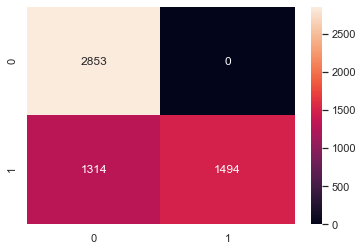

In [566]:
#Confusion matrix
cm = confusion_matrix(y_test, preds_xgb)
sns.heatmap(cm, annot=True, fmt="d")

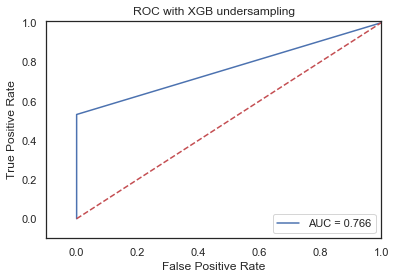

In [569]:
# y_pred_xgb = tmp.decision_function(X_test)

fpr, tpr, thresholds = roc_curve(y_test, preds_xgb)

roc_auc = auc(fpr,tpr)

# Plot ROC
plt.title('ROC with XGB undersampling')
plt.plot(fpr, tpr, 'b',label='AUC = %0.3f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [453]:
# Support Vector Classifier
svc_params = {'C': [0.5, 0.7, 0.9, 1], 'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}
grid_svc = GridSearchCV(SVC(), svc_params)
grid_svc.fit(X_train, y_train)

# SVC best estimator
svc = grid_svc.best_estimator_

KeyboardInterrupt: 

In [ ]:
# We will undersample during cross validating
undersample_X = df.drop('class', axis=1)
undersample_y = df['class']

for train_index, test_index in sss.split(undersample_X, undersample_y):
    print("Train:", train_index, "Test:", test_index)
    undersample_Xtrain, undersample_Xtest = undersample_X.iloc[train_index], undersample_X.iloc[test_index]
    undersample_ytrain, undersample_ytest = undersample_y.iloc[train_index], undersample_y.iloc[test_index]
    
undersample_Xtrain = undersample_Xtrain.values
undersample_Xtest = undersample_Xtest.values
undersample_ytrain = undersample_ytrain.values
undersample_ytest = undersample_ytest.values 

undersample_accuracy = []
undersample_precision = []
undersample_recall = []
undersample_f1 = []
undersample_auc = []

# Implementing NearMiss Technique 
# Distribution of NearMiss (Just to see how it distributes the labels we won't use these variables)
X_nearmiss, y_nearmiss = NearMiss().fit_sample(undersample_X.values, undersample_y.values)
print('NearMiss Label Distribution: {}'.format(Counter(y_nearmiss)))
# Cross Validating the right way

for train, test in sss.split(undersample_Xtrain, undersample_ytrain):
    undersample_pipeline = imbalanced_make_pipeline(NearMiss(sampling_strategy='majority'), log_reg) # SMOTE happens during Cross Validation not before..
    undersample_model = undersample_pipeline.fit(undersample_Xtrain[train], undersample_ytrain[train])
    undersample_prediction = undersample_model.predict(undersample_Xtrain[test])
    
    undersample_accuracy.append(undersample_pipeline.score(original_Xtrain[test], original_ytrain[test]))
    undersample_precision.append(precision_score(original_ytrain[test], undersample_prediction))
    undersample_recall.append(recall_score(original_ytrain[test], undersample_prediction))
    undersample_f1.append(f1_score(original_ytrain[test], undersample_prediction))
    undersample_auc.append(roc_auc_score(original_ytrain[test], undersample_prediction))

### 3.5 Oversampling with SMOTE

In [521]:
# Separate target variable Y from features X

target_name = 'class'
df_small.drop(columns=['user_id', 'device_id', 'ip_address'], inplace=True)

print("Separating labels from features...")
X = df_small.drop(target_name, axis=1)
y = df_small[target_name]

# # Convert pandas DataFrames to numpy arrays before using scikit-learn

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Separating labels from features...


In [522]:
df_small

,purchase_value,source,browser,sex,age,class,country,duration
16174,49,SEO,Safari,M,44,1,Canada,1.0
36005,31,Ads,Chrome,F,22,0,United States,3406789.0
49819,26,SEO,Chrome,M,48,0,unknown,7421778.0
43667,37,SEO,Chrome,M,26,0,Philippines,7354320.0
122724,20,Ads,Safari,F,27,1,United Kingdom,9212044.0
...,...,...,...,...,...,...,...,...
45239,32,SEO,Chrome,F,19,0,Czech Republic,2019331.0
111483,65,Ads,IE,M,38,1,European Union,953310.0
146387,38,Direct,Chrome,M,42,1,United States,1.0
144672,40,SEO,Chrome,M,31,0,Germany,8309515.0


In [524]:
# Create pipeline for numeric features
numeric_features = ['purchase_value', 'age', 'duration'] # Positions of numeric columns in X_train/X_test
numeric_transformer = Pipeline(
    steps=[
    ('scaler', StandardScaler())
])

# Create pipeline for categorical features
categorical_features = ['source', 'browser', 'sex', 'country'] # Positions of categorical columns in X_train/X_test
categorical_transformer = Pipeline(
    steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore')) 
        # first column will be dropped to avoid creating correlations between features
    ])

# Use ColumnTranformer to make a preprocessor object that describes all the treatments to be done
preprocessor_models = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [ ]:
#Pre-proccesing
X_train = preprocessor_models.fit_transform(X_train)
X_test = preprocessor_models.fit_transform(X_test)

In [ ]:
smote=SMOTE(sampling_strategy='minority')
X_sm, y_sm=smote.fit_sample(X,y)

In [439]:
np.bincount(y_train)

array([11298, 11343])

In [432]:
logmodel3=LogisticRegression()
r3=logmodel3.fit(X_sm, y_sm)
r3

LogisticRegression()

In [492]:
pred3=logmodel3.predict(X_sm)
accuracy3=logmodel3.score(X_sm, y_sm)
accuracy3

ValueError: could not convert string to float: 'Direct'

,purchase_value,source,browser,sex,age,class,country,duration
144432,9,Direct,Chrome,F,36,1,United Arab Emirates,1.0
23023,46,SEO,IE,M,34,0,United States,5238440.0
47503,36,Direct,IE,F,47,0,United States,9440566.0
115784,10,Ads,Chrome,F,28,0,Germany,2949696.0
42376,33,Direct,Chrome,M,38,1,Brazil,1795616.0
...,...,...,...,...,...,...,...,...
95963,62,Ads,Safari,F,35,0,Taiwan; Republic of China (ROC),8017733.0
142209,69,Ads,Opera,M,36,1,Brazil,972854.0
84418,49,Direct,IE,F,35,1,United States,2947452.0
33417,35,SEO,Chrome,M,34,0,United States,8081272.0


# 4. Oversampling 

In [534]:
df

,purchase_value,source,browser,sex,age,class,country,duration
16987,46,SEO,FireFox,F,24,0,unknown,8175929.0
64595,56,Ads,FireFox,M,49,0,Japan,9779163.0
124205,17,Direct,FireFox,F,42,0,France,968716.0
70234,34,SEO,IE,F,55,0,United States,7314764.0
61284,29,SEO,Chrome,M,45,0,unknown,2510794.0
...,...,...,...,...,...,...,...,...
94777,18,Direct,FireFox,F,23,0,France,60395.0
2833,39,SEO,Safari,M,21,0,Poland,6354841.0
149653,40,Direct,Chrome,M,42,0,United States,3543123.0
8539,80,Ads,Chrome,M,38,0,United States,9666423.0


In [535]:
#Pre-processing:

# df_o=df.drop(columns=['user_id', 'device_id', 'ip_address'], inplace=True)

X = pd.get_dummies(df.drop("class", axis=1),drop_first= True)
y = df["class"]

# Splitting dataset
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state = 42,
                                                    stratify = y,
                                                    test_size = 0.25
                                                   )
# We normalise X_train et X_test with StandardScalar

StdS_o = StandardScaler()

X_train = StdS_o.fit_transform(X_train)
X_test = StdS_o.transform(X_test)

In [536]:
#Now oversampling with SMOTE

print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train==0)))

sm = SMOTE(random_state=2)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train.ravel())

print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train_res==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res==0)))

Before OverSampling, counts of label '1': 10613
Before OverSampling, counts of label '0': 102721 

After OverSampling, the shape of train_X: (205442, 136)
After OverSampling, the shape of train_y: (205442,) 

After OverSampling, counts of label '1': 102721
After OverSampling, counts of label '0': 102721


In [538]:
X_train_res

array([[ 0.65496104, -1.17677454, -0.54694916, ..., -0.00664224,
        -0.03362562, -0.41299387],
       [ 0.38256913, -0.01554535, -0.98903572, ..., -0.00664224,
        -0.03362562,  2.42134347],
       [-0.70699848, -0.01554535, -0.14961247, ..., -0.00664224,
        -0.03362562, -0.41299387],
       ...,
       [ 0.81839618,  0.68119216, -1.5785583 , ..., -0.00664224,
        -0.03362562, -0.41299387],
       [ 0.03082691, -0.51671576, -1.28742563, ..., -0.00664224,
        -0.03362562, -0.41299387],
       [-0.924912  , -0.9445287 , -1.5785583 , ..., -0.00664224,
        -0.03362562, -0.41299387]])

In [542]:
parameters = {
    'C': np.linspace(1, 10, 10)
             }
lr = LogisticRegression()
clf = GridSearchCV(lr, parameters, cv=5, verbose=5, n_jobs=3)
clf.fit(X_train_res, y_train_res.ravel())

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed:   17.0s
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:  1.2min finished


GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=3,
             param_grid={'C': array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])},
             verbose=5)

In [543]:
clf.best_params_


{'C': 8.0}

In [547]:
lr1 = LogisticRegression(C=8,penalty='l1', verbose=3, solver='liblinear')
lr1.fit(X_train_res, y_train_res.ravel())

[LibLinear]

LogisticRegression(C=8, penalty='l1', solver='liblinear', verbose=3)

In [549]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        1#print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [594]:
y_train_pre = lr1.predict(X_train)

cnf_matrix_tra = confusion_matrix(y_train, y_train_pre)

print("Recall in dataset: {}%".format(cnf_matrix_tra[1,1]/(cnf_matrix_tra[1,0]+cnf_matrix_tra[1,1])))


class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix_tra , classes=class_names, title='Confusion matrix')
plt.show()

ValueError: X has 134 features per sample; expecting 136

Recall metric in the testing dataset: 68.85245901639344%


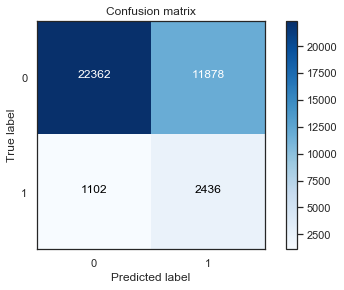

In [551]:
y_pre = lr1.predict(X_test)

cnf_matrix = confusion_matrix(y_test, y_pre)

print("Recall metric in the testing dataset: {}%".format(100*cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1])))
#print("Precision metric in the testing dataset: {}%".format(100*cnf_matrix[0,0]/(cnf_matrix[0,0]+cnf_matrix[1,0])))
# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix , classes=class_names, title='Confusion matrix')
plt.show()

In [552]:
tmp = lr1.fit(X_train_res, y_train_res.ravel())


[LibLinear]

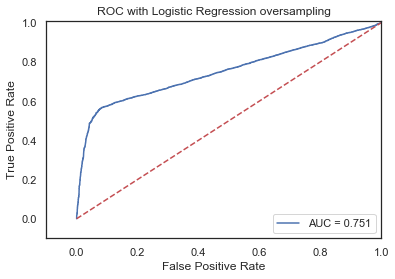

In [559]:
y_pred_sample_score = tmp.decision_function(X_test)


fpr, tpr, thresholds = roc_curve(y_test, y_pred_sample_score)

roc_auc = auc(fpr,tpr)

# Plot ROC
plt.title('ROC with Logistic Regression oversampling')
plt.plot(fpr, tpr, 'b',label='AUC = %0.3f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()